In [1]:
import pandas as pd
import numpy as np
from numpy.random import *
import datetime
import math
import os
import matplotlib.pyplot as plt
from pylab import rcParams

plt.style.use('ggplot')
%pylab inline --no-import-all

def lorenz(x):
    s = 10
    R = 28
    b = 8/3
    
    dx = np.array([-s*x[0]-x[1], R*x[0]-x[1]-x[0]*x[2], -b*x[2]+x[0]*x[1]])
    
    return dx
 
def myoutput(x,t): #2D_行
    x=second_row(x)
    x=x #+ 0.1*second_row(np.dot(R,np.random.normal(0, 1, (3, 1))))
    return second_row(x)

def second_row(x):    #行
    return x.reshape(1,-1)

def second_column(x):     #列
    return x.reshape(-1,1)

def row2array(x):
    return x[0,:]

def column2array(x):
    x=x.T
    return x[0,:]


Populating the interactive namespace from numpy and matplotlib


##  Here, we perform estimation simulation using nonlinear dynamics called Lorenz equation.

$$
    \sigma = 10, r = 28, b = \frac{8}{3}
$$

$$
    {\dot{x} = \sigma(y-x)\\
\dot{y} = rx -y-z\\
\dot{z} = -bz + xy
}
$$

In [2]:
#分散の初期設定
Rtr = 0.3
R = np.diag([0.5, 0.2, 0.1]) #3D
Q = np.diag([2, 4, 3])  #3D
dt = 0.01 

# 真値の計算
t = np.linspace(0,10,10/dt+1,dtype=float)#時間　dt=0.01の間隔で0から10秒までの配列
xtr0 = np.array([2, 10, 1]).reshape(1,-1) #2D行 #真値の初期値、行列xtr0の1番目の行
ytr = myoutput(xtr0,t[0])#2D行#真値の出力
yt = myoutput(xtr0,t[0])#2D行
w0=np.dot(Q,np.random.normal(0, 1, (3, 1)))    #2D列
w=w0    #2D列
xtr = xtr0     #2D行

for i in range(len(t)):
    k1 = lorenz(xtr[i,:] ) #array
    k2 = lorenz(xtr[i,:] +dt*k1/2 )   #array
    k3 = lorenz(xtr[i,:] +dt*k2/2)   #array
    k4 = lorenz(xtr[i,:] +dt*k3)    #array
    w_i = np.dot(Q,np.random.normal(0, 1, (3, 1)))#2D_列 正規乱数
    #w_i = second_row(np.dot(Q,np.random.rand(3)))#2D_列　一様乱数
    xtr_t = (xtr[i,:]  + dt* (k1+2*k2+2*k3+k4)/6 + w_i[:,0].T*dt)
    xtr_t = second_row(xtr_t) #2D_行
    xtr = np.concatenate([xtr,xtr_t],axis=0) #3D_行
    ytr_t = myoutput(xtr[i,:],t[i])#2D_行
    yt_t = ytr_t+second_row(np.dot(R,np.random.normal(0, 1, (3, 1))))   #2D_行　正規乱数
    #yt_t = ytr_t+second_row(np.dot(R,np.random.rand(3)))   #2D_行　一様乱数
    ytr = np.concatenate([ytr,ytr_t],axis=0)#3D_行
    yt = np.concatenate([yt,yt_t],axis=0)    #3D_行


#np.dot(R,np.random.uniform(0, 1, (3, 1))) は2D_列

#3D_行を3D_列へ戻す
xtr=xtr.T#3D_列
ytr=ytr.T#3D_列
yt=yt.T#3D_列

#1002列目を削除する
xtr=np.delete(xtr, 1001, 1)
#1列目を削除する
ytr=np.delete(ytr, 0, 1)
yt=np.delete(yt, 0, 1)

print(yt.shape)
print(w_i)


(3, 1001)
[[-0.64315452]
 [-2.85470519]
 [-1.68270634]]


In [3]:
print(xtr.shape[1])
print(xtr.shape)

1001
(3, 1001)


In [4]:
#  EnKFの初期設定
M = 100   #サンプルの数
barx0 = second_column(np.array([2,10,1]))  #状態の初期値 2D_列
P0 = np.diag([1, 3, 3])  #共分散行列の初期値  3D

# アンサンブル行列X_0/tの作成
x0=second_row(barx0) #2D_行

for i in range(M-1):
        x0_i=second_row(barx0 + np.dot(Q,np.random.normal(0, 1, (3, 1))))  #2D_行　正規乱数
        x0 = np.concatenate([x0,x0_i],axis=0) #3D_行
        

#3D_行を3D_列へ戻す
x0=x0.T

#1列目を削除する
#x0=np.delete(x0, 0, 1)        
        
print(x0.shape)
print(x0[:,0])   #array  #1D_列

# アンサンブル行列Y_0/tの作成
y0 = myoutput(x0[:,0].T,t[0])

for i in range(M-1):
        y0_i=myoutput(x0[:,i].T,t[0]) + second_row(np.dot(R,np.random.normal(0, 1, (3, 1))))#2D_行　正規乱数
        y0 = np.concatenate([y0,y0_i],axis=0) #3D_行

        
#3D_行を3D_列へ戻す
y0=y0.T

#1列目を削除する
#y0=np.delete(y0, 0, 1)        
        
print(y0.shape)
print(barx0)
print(x0[:,0])

(3, 100)
[  2.  10.   1.]
(3, 100)
[[ 2]
 [10]
 [ 1]]
[  2.  10.   1.]


In [5]:
A = np.eye(1,100)
B = np.array([[1, -1],[-1,1]])
#K = np.kron(A,B)
print(A.shape)
print(B)


(1, 100)
[[ 1 -1]
 [-1  1]]


In [6]:
#Ensemble Kalman Filterの計算

#誤差アンサンブル行列の作成

yest=second_column(ytr[:,0])

for i in range(len(t)-1):
    x=np.array([[0],[0],[0]])
    ### EnKF: 観測更新ステップ ###
    xhat = second_column(numpy.sum(x0,axis=1) / M ) #2D_列
    yhat = second_column(numpy.sum(y0,axis=1) / M ) #2D_列
    yest_i = yhat
    yest = np.concatenate([yest,yest_i],axis=1) #3D_列
    
    if i == 0:
        yest = np.delete(x, 0, 1)  #1列目を削除する
    
    Pxy = np.dot( (np.kron(np.eye(1,100),xhat) - x0), (np.kron(np.eye(1,100),yhat) - y0).T ) / (M-1)  #(3x3)  U 共分散行列
    Pyy = np.dot( (np.kron(np.eye(1,100),yhat) - y0), (np.kron(np.eye(1,100),yhat) - y0).T ) / (M-1)  #(3x3)  V 共分散行列
    K = np.dot(Pxy, np.linalg.inv(Pyy))     #np.linalg.inv(A) Aの逆行列 カルマンゲイン  #(3x3)
    
    ### EnKF: 予測更新ステップ  ###
    for j in range(M-1):
        #x_j = x0[:,j] 
        x_j = second_column( x0[:,j] + np.dot(K, yt[:,i] - y0[:,j]) ) #2D_列
        x = np.concatenate([x,x_j],axis=1) #3D_列
        x0[:,j] = x[:,j] + column2array(second_row(lorenz(x[:,j])).T*dt +np.dot(Q,np.random.normal(0, 1, (3, 1))) * dt )  #array型
        
        #x0 = second_row(lorenz(x[:,j])).T*dt   #2D_列
        #x0 = np.dot(Q,np.random.normal(0, 1, (3, 1))) * dt #2D_列
        
        y0[:,j] = column2array(  myoutput(x0[:,j],t[i+1]) + np.dot(R, np.random.normal(0, 1, (3, 1)) ) )    #array型
        #y3 = myoutput(x0[:,j],t[i+1]) #2D_列
        #y3 = np.dot(R, np.random.normal(0, 1, (3, 1))) #2D_列
        
        #if  j == 0 :
        #    x = np.delete(x, 0, 1)  #1列目を削除する
            
#推定値の要素数を合わせるため、yest_0を1001列目に挿入
yest = np.concatenate([second_column(ytr[:,0]),yest],axis=1) #3D_列   
yest = np.concatenate([yest,yest_i],axis=1) #3D_列       
  

print(xtr.shape)
print(yest.shape)
print(len(t)-1)
print(second_column(ytr[:,0]))
print(ytr.shape)
print(x.shape)


(3, 1001)
(3, 1001)
1000
[[  2.]
 [ 10.]
 [  1.]]
(3, 1001)
(3, 100)


In [7]:
#print(t.shape)  #(201,) tの真値
#print(xtr.shape)  #(3, 201) xの真値
#print(ytr.shape)  #(3, 201) yの真値
#print(yest.shape)  #(3, 201) yestの真値 #便宜上t=0　を挿入している。

print(xtr[0,:].shape)


(1001,)


In [8]:
df = pd.DataFrame({ 't' : t ,
                    'xtr1' : xtr[0,:],
                    'xtr2' : xtr[1,:],
                    'xtr3' : xtr[2,:],
                    'ytr1' : ytr[0,:],
                    'ytr2' : ytr[1,:],
                    'ytr3' : ytr[2,:],
                    'yest1' : yest[0,:],
                    'yest2' : yest[1,:],
                    'yest3' : yest[2,:],
                  })
df[:10]

,t,xtr1,xtr2,xtr3,yest1,yest2,yest3,ytr1,ytr2,ytr3
0,0.00,2.000000,10.000000,1.000000,2.000000,10.000000,1.000000,2.000000,10.000000,1.000000
1,0.01,1.729614,10.359368,1.114648,1.657929,1.836748,1.671536,1.729614,10.359368,1.114648
2,0.02,1.473760,10.689617,1.200607,2.277600,2.415361,2.248228,1.473760,10.689617,1.200607
3,0.03,1.215007,10.876417,1.323721,2.412178,2.566562,2.418003,1.215007,10.876417,1.323721
4,0.04,1.012147,11.106152,1.353545,2.553160,2.657042,2.499494,1.012147,11.106152,1.353545
5,0.05,0.810318,11.274136,1.447351,2.663275,2.771161,2.583509,0.810318,11.274136,1.447351
6,0.06,0.640336,11.408243,1.438229,2.501793,2.689755,2.504860,0.640336,11.408243,1.438229
7,0.07,0.467002,11.465650,1.469899,2.586580,2.658460,2.525008,0.467002,11.465650,1.469899
8,0.08,0.336738,11.467775,1.429865,2.530185,2.730222,2.525695,0.336738,11.467775,1.429865
9,0.09,0.170041,11.484722,1.404946,2.477943,2.588126,2.381460,0.170041,11.484722,1.404946


/home/ec2-user/.pyenv/versions/anaconda3-4.0.0/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/ec2-user/.pyenv/versions/anaconda3-4.0.0/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


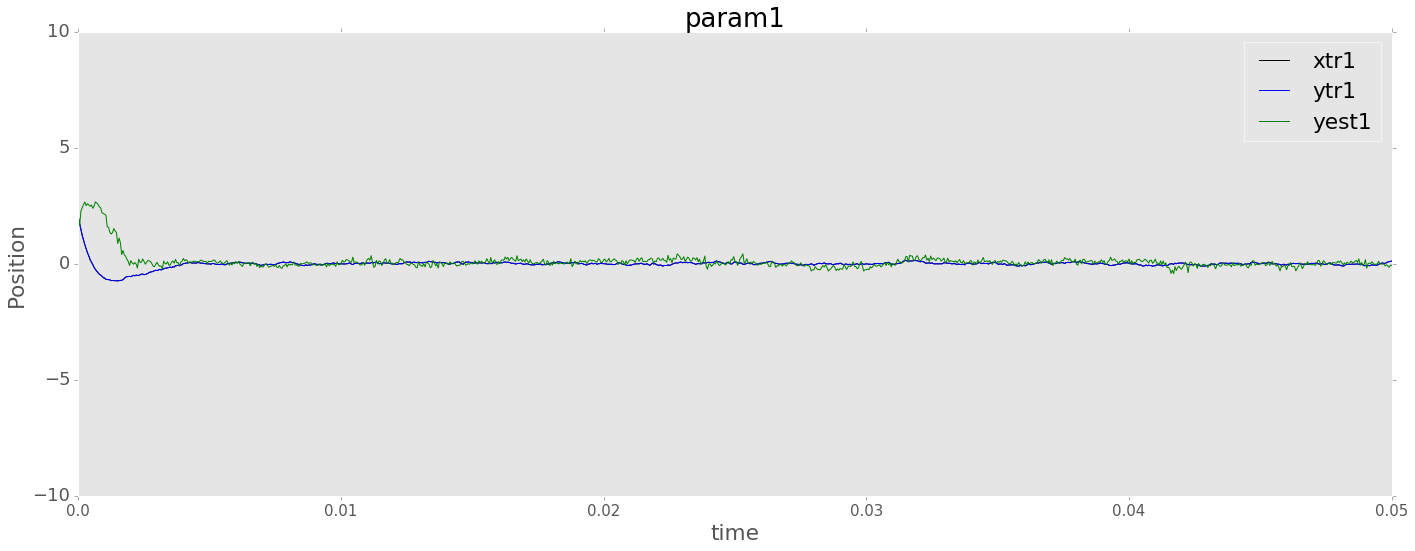

In [9]:
from matplotlib import cm
import matplotlib.dates as mdates
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

rcParams['figure.figsize'] = 20,8
plt.rcParams["font.size"] = 18


input1 = df['t']
output0 = df['xtr1']
output1 = df['ytr1']
output2 = df['yest1']

fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ax1.plot(input1, output0, color='black',linestyle='solid', linewidth = 1, label='xtr1')
ax1.plot(input1, output1, color='blue',linestyle='solid', linewidth = 1, label='ytr1')
ax1.set_ylim([0, 10])
ax1.set_ylim([-10, 10])
ax1.plot(input1, output2, color='green', linewidth = 1, label='yest1')
ax1.set_title('param1')
ax1.set_xlabel('time')
ax1.set_ylabel('Position')
ax1.set_xticklabels(input1,rotation=0, size="small")


plt.legend()

ax1.grid(False) #目盛のごちゃごちゃ変更

fig.show()

/home/ec2-user/.pyenv/versions/anaconda3-4.0.0/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/ec2-user/.pyenv/versions/anaconda3-4.0.0/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


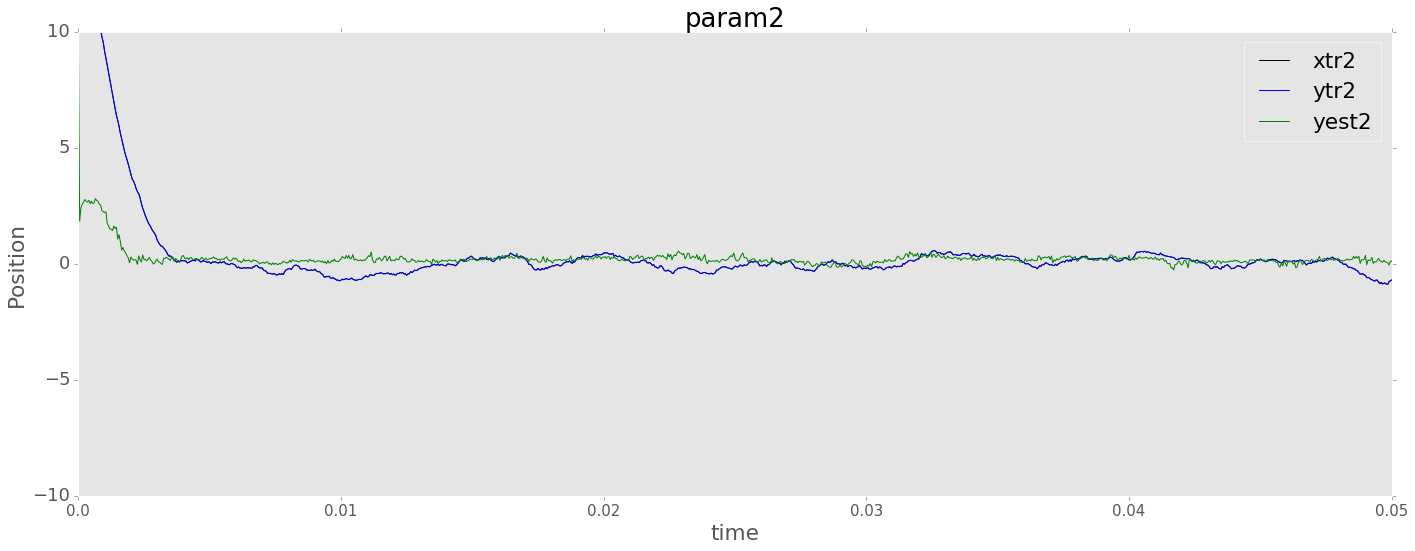

In [10]:
rcParams['figure.figsize'] = 20,8
plt.rcParams["font.size"] = 18


input1 = df['t']
output0 = df['xtr2']
output1 = df['ytr2']
output2 = df['yest2']

fig2 = plt.figure()
ax2 = fig2.add_subplot(1,1,1)
ax2.plot(input1, output0, color='black',linestyle='solid', linewidth = 1, label='xtr2')
ax2.plot(input1, output1, color='blue',linestyle='solid', linewidth = 1, label='ytr2')
ax2.set_ylim([0, 10])
ax2.set_ylim([-10, 10])
ax2.plot(input1, output2, color='green', linewidth = 1, label='yest2')
ax2.set_title('param2')
ax2.set_xlabel('time')
ax2.set_ylabel('Position')
ax2.set_xticklabels(input1,rotation=0, size="small")


plt.legend()

ax2.grid(False) #目盛のごちゃごちゃ変更

fig2.show()